<a href="https://colab.research.google.com/github/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/blob/main/PyTorch_L2_PGD_Untargeted_Attack_using_ImageNet_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 6068 (delta 30), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6068/6068), 630.79 MiB | 50.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (5006/5006), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [4]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [5]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [6]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [7]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float)

In [8]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [9]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

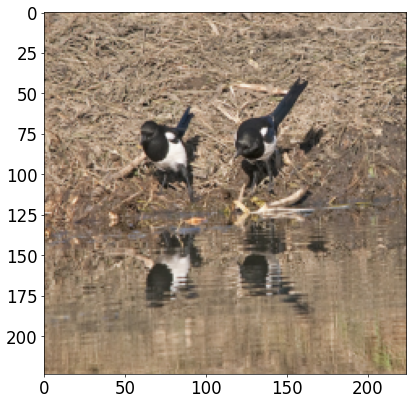

In [10]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [11]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [13]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


#### <b>Load Validation Dataset</b>

In [20]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Validation dataset size:', len(val_dataset))

class_names = val_dataset.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


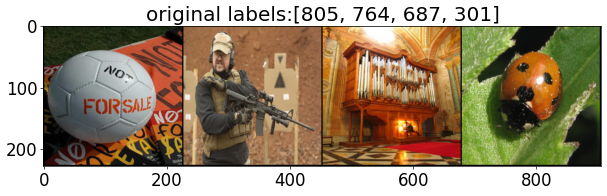

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: soccer ball (805)
Image #2: rifle (764)
Image #3: organ, pipe organ (687)
Image #4: ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle (301)


In [21]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

[Prediction Result Examples]


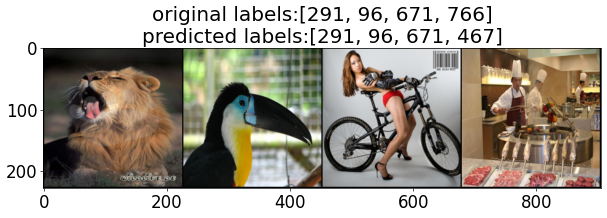

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: lion, king of beasts, Panthera leo (291)
Image #2: toucan (96)
Image #3: mountain bike, all-terrain bike, off-roader (671)
Image #4: rotisserie (766)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: lion, king of beasts, Panthera leo (291)
Image #2: toucan (96)
Image #3: mountain bike, all-terrain bike, off-roader (671)
Image #4: butcher shop, meat market (467)


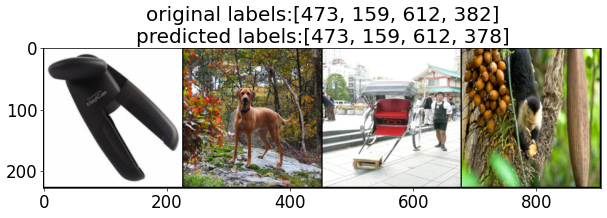

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: can opener, tin opener (473)
Image #6: Rhodesian ridgeback (159)
Image #7: jinrikisha, ricksha, rickshaw (612)
Image #8: squirrel monkey, Saimiri sciureus (382)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: can opener, tin opener (473)
Image #6: Rhodesian ridgeback (159)
Image #7: jinrikisha, ricksha, rickshaw (612)
Image #8: capuchin, ringtail, Cebus capucinus (378)
[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 34.4237s (total 5000 images)


In [22]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [26]:
!pip install foolbox
!pip install advertorch

In [27]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: 4-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 0.25

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


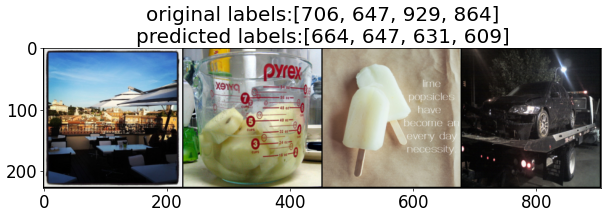

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: patio, terrace (706)
Image #2: measuring cup (647)
Image #3: ice lolly, lolly, lollipop, popsicle (929)
Image #4: tow truck, tow car, wrecker (864)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: monitor (664)
Image #2: measuring cup (647)
Image #3: lotion (631)
Image #4: jeep, landrover (609)


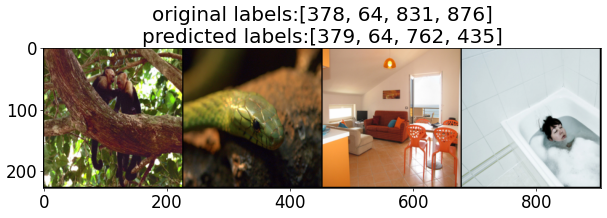

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: capuchin, ringtail, Cebus capucinus (378)
Image #6: green mamba (64)
Image #7: studio couch, day bed (831)
Image #8: tub, vat (876)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: howler monkey, howler (379)
Image #6: green mamba (64)
Image #7: restaurant, eating house, eating place, eatery (762)
Image #8: bathtub, bathing tub, bath, tub (435)
[Step #0] Loss: 0.3524 Accuracy: 25.0000% Time elapsed: 1.4776s (total 16 images)
[Step #10] Loss: 0.3274 Accuracy: 22.7273% Time elapsed: 8.7789s (total 176 images)
[Step #20] Loss: 0.3265 Accuracy: 21.4286% Time elapsed: 16.2382s (total 336 images)
[Step #30] Loss: 0.3139 Accuracy: 22.5806% Time elapsed: 23.9465s (total 496 images)
[Step #40] Loss: 0.3101 Accuracy: 23.1707% Time elapsed: 31.8486s (total 656 images)
[Step #50] Loss: 0.3051 Accuracy: 24.1422% Time elapsed: 39.6216s (total 816 images)
[Step #60] Loss: 0.3109 Accuracy: 24.0779% Time elapsed: 47.1878s (total 976 images)
[Step 

In [29]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.25, nb_iter=4, eps_iter=0.25/2, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 0.25

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


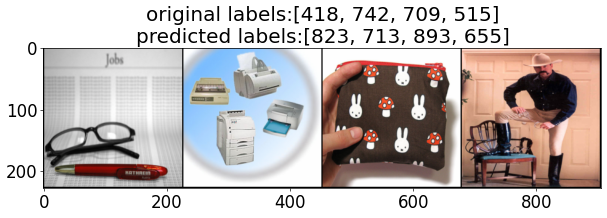

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ballpoint, ballpoint pen, ballpen, Biro (418)
Image #2: printer (742)
Image #3: pencil box, pencil case (709)
Image #4: cowboy hat, ten-gallon hat (515)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: stethoscope (823)
Image #2: photocopier (713)
Image #3: wallet, billfold, notecase, pocketbook (893)
Image #4: miniskirt, mini (655)


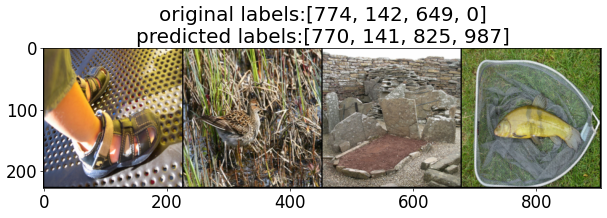

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: sandal (774)
Image #6: dowitcher (142)
Image #7: megalith, megalithic structure (649)
Image #8: tench, Tinca tinca (0)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: running shoe (770)
Image #6: redshank, Tringa totanus (141)
Image #7: stone wall (825)
Image #8: corn (987)
[Step #0] Loss: 0.2910 Accuracy: 18.7500% Time elapsed: 2.0769s (total 16 images)
[Step #10] Loss: 0.2796 Accuracy: 28.9773% Time elapsed: 14.6041s (total 176 images)
[Step #20] Loss: 0.3035 Accuracy: 25.8929% Time elapsed: 27.1469s (total 336 images)
[Step #30] Loss: 0.3045 Accuracy: 23.1855% Time elapsed: 39.7128s (total 496 images)
[Step #40] Loss: 0.3064 Accuracy: 24.0854% Time elapsed: 52.2850s (total 656 images)
[Step #50] Loss: 0.3088 Accuracy: 25.0000% Time elapsed: 64.8255s (total 816 images)
[Step #60] Loss: 0.3087 Accuracy: 25.3074% Time elapsed: 77.3272s (total 976 images)
[Step #70] Loss: 0.3073 Accuracy: 26.0563% Time elapsed: 89.8425s (total 113

In [30]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.25, nb_iter=7, eps_iter=0.25/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: 4-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 0.5

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


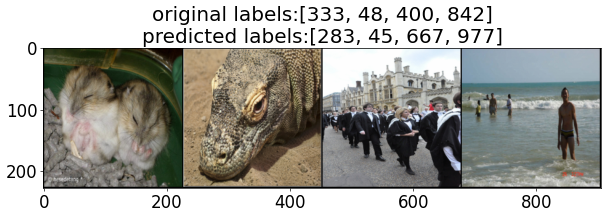

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: hamster (333)
Image #2: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis (48)
Image #3: academic gown, academic robe, judge's robe (400)
Image #4: swimming trunks, bathing trunks (842)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Persian cat (283)
Image #2: Gila monster, Heloderma suspectum (45)
Image #3: mortarboard (667)
Image #4: sandbar, sand bar (977)


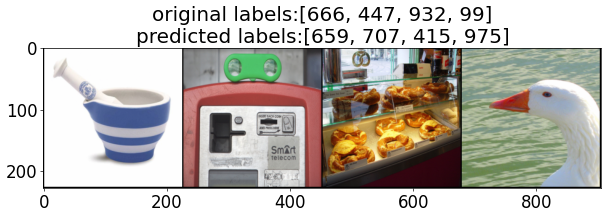

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: mortar (666)
Image #6: binoculars, field glasses, opera glasses (447)
Image #7: pretzel (932)
Image #8: goose (99)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: mixing bowl (659)
Image #6: pay-phone, pay-station (707)
Image #7: bakery, bakeshop, bakehouse (415)
Image #8: lakeside, lakeshore (975)
[Step #0] Loss: 0.4950 Accuracy: 6.2500% Time elapsed: 1.4416s (total 16 images)
[Step #10] Loss: 0.5670 Accuracy: 4.5455% Time elapsed: 8.7998s (total 176 images)
[Step #20] Loss: 0.5795 Accuracy: 5.0595% Time elapsed: 16.1694s (total 336 images)
[Step #30] Loss: 0.5718 Accuracy: 6.2500% Time elapsed: 23.5539s (total 496 images)
[Step #40] Loss: 0.5699 Accuracy: 6.5549% Time elapsed: 30.9399s (total 656 images)
[Step #50] Loss: 0.5758 Accuracy: 6.9853% Time elapsed: 38.3300s (total 816 images)
[Step #60] Loss: 0.5781 Accuracy: 6.8648% Time elapsed: 45.7428s (total 976 images)
[Step #70] Loss: 0.5864 Accuracy: 6.8662% Time elapsed: 53.

In [31]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.5, nb_iter=4, eps_iter=0.5/2, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 0.5

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


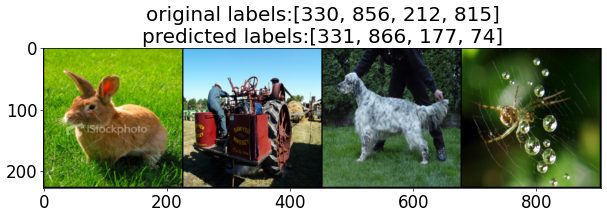

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: wood rabbit, cottontail, cottontail rabbit (330)
Image #2: thresher, thrasher, threshing machine (856)
Image #3: English setter (212)
Image #4: spider web, spider's web (815)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: hare (331)
Image #2: tractor (866)
Image #3: Scottish deerhound, deerhound (177)
Image #4: garden spider, Aranea diademata (74)


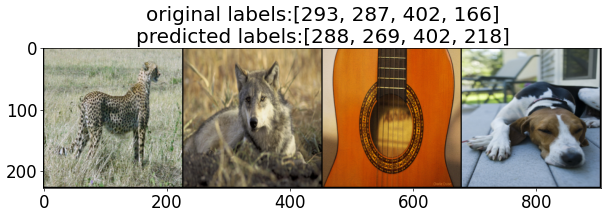

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: cheetah, chetah, Acinonyx jubatus (293)
Image #6: lynx, catamount (287)
Image #7: acoustic guitar (402)
Image #8: Walker hound, Walker foxhound (166)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: leopard, Panthera pardus (288)
Image #6: timber wolf, grey wolf, gray wolf, Canis lupus (269)
Image #7: acoustic guitar (402)
Image #8: Welsh springer spaniel (218)
[Step #0] Loss: 0.6772 Accuracy: 12.5000% Time elapsed: 1.9694s (total 16 images)
[Step #10] Loss: 0.5954 Accuracy: 8.5227% Time elapsed: 14.4663s (total 176 images)
[Step #20] Loss: 0.6102 Accuracy: 6.8452% Time elapsed: 26.9774s (total 336 images)
[Step #30] Loss: 0.6277 Accuracy: 6.4516% Time elapsed: 39.4846s (total 496 images)
[Step #40] Loss: 0.6225 Accuracy: 7.0122% Time elapsed: 52.0123s (total 656 images)
[Step #50] Loss: 0.6364 Accuracy: 6.9853% Time elapsed: 64.5382s (total 816 images)
[Step #60] Loss: 0.6407 Accuracy: 6.9672% Time elapsed: 77.0535s (total 976 im

In [32]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.5, nb_iter=7, eps_iter=0.5/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1.0

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


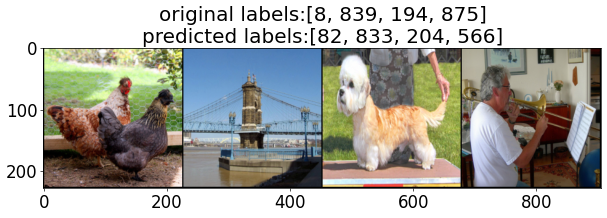

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: hen (8)
Image #2: suspension bridge (839)
Image #3: Dandie Dinmont, Dandie Dinmont terrier (194)
Image #4: trombone (875)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ruffed grouse, partridge, Bonasa umbellus (82)
Image #2: submarine, pigboat, sub, U-boat (833)
Image #3: Lhasa, Lhasa apso (204)
Image #4: French horn, horn (566)


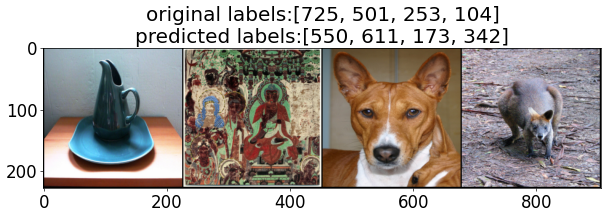

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: pitcher, ewer (725)
Image #6: cloak (501)
Image #7: basenji (253)
Image #8: wallaby, brush kangaroo (104)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: espresso maker (550)
Image #6: jigsaw puzzle (611)
Image #7: Ibizan hound, Ibizan Podenco (173)
Image #8: wild boar, boar, Sus scrofa (342)
[Step #0] Loss: 1.2595 Accuracy: 0.0000% Time elapsed: 2.0053s (total 16 images)
[Step #10] Loss: 1.1587 Accuracy: 0.0000% Time elapsed: 14.5536s (total 176 images)
[Step #20] Loss: 1.1288 Accuracy: 0.5952% Time elapsed: 27.0838s (total 336 images)
[Step #30] Loss: 1.1036 Accuracy: 0.6048% Time elapsed: 39.6162s (total 496 images)
[Step #40] Loss: 1.1249 Accuracy: 0.4573% Time elapsed: 52.1474s (total 656 images)
[Step #50] Loss: 1.1141 Accuracy: 0.9804% Time elapsed: 64.6777s (total 816 images)
[Step #60] Loss: 1.1190 Accuracy: 1.1270% Time elapsed: 77.2006s (total 976 images)
[Step #70] Loss: 1.1248 Accuracy: 1.1444% Time elapsed: 89.7398s

In [33]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1.0, nb_iter=7, eps_iter=1.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 2.0

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


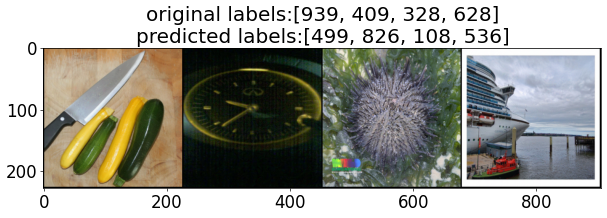

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: zucchini, courgette (939)
Image #2: analog clock (409)
Image #3: sea urchin (328)
Image #4: liner, ocean liner (628)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cleaver, meat cleaver, chopper (499)
Image #2: stopwatch, stop watch (826)
Image #3: sea anemone, anemone (108)
Image #4: dock, dockage, docking facility (536)


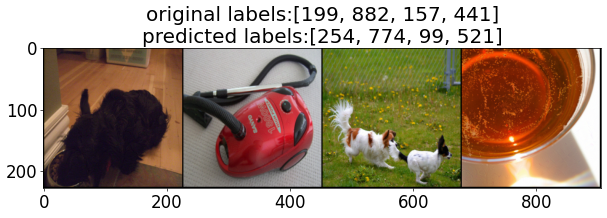

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Scotch terrier, Scottish terrier, Scottie (199)
Image #6: vacuum, vacuum cleaner (882)
Image #7: papillon (157)
Image #8: beer glass (441)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: pug, pug-dog (254)
Image #6: sandal (774)
Image #7: goose (99)
Image #8: Crock Pot (521)
[Step #0] Loss: 1.6605 Accuracy: 0.0000% Time elapsed: 1.9585s (total 16 images)
[Step #10] Loss: 1.6601 Accuracy: 0.0000% Time elapsed: 14.4323s (total 176 images)
[Step #20] Loss: 1.6979 Accuracy: 0.0000% Time elapsed: 26.9431s (total 336 images)
[Step #30] Loss: 1.7028 Accuracy: 0.0000% Time elapsed: 39.4713s (total 496 images)
[Step #40] Loss: 1.6979 Accuracy: 0.0000% Time elapsed: 51.9994s (total 656 images)
[Step #50] Loss: 1.6866 Accuracy: 0.1225% Time elapsed: 64.5359s (total 816 images)
[Step #60] Loss: 1.6906 Accuracy: 0.2049% Time elapsed: 77.0857s (total 976 images)
[Step #70] Loss: 1.6972 Accuracy: 0.2641% Time elapsed: 89.6339s (total 1136 image

In [34]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2.0, nb_iter=7, eps_iter=2.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 7</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 4.0

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


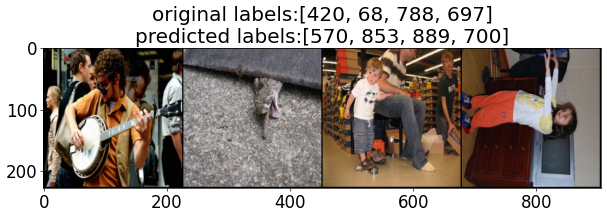

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: banjo (420)
Image #2: sidewinder, horned rattlesnake, Crotalus cerastes (68)
Image #3: shoe shop, shoe-shop, shoe store (788)
Image #4: pajama, pyjama, pj's, jammies (697)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: gasmask, respirator, gas helmet (570)
Image #2: thatch, thatched roof (853)
Image #3: violin, fiddle (889)
Image #4: paper towel (700)


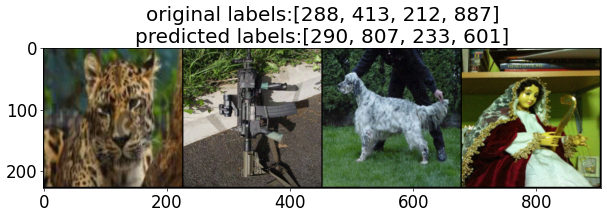

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: leopard, Panthera pardus (288)
Image #6: assault rifle, assault gun (413)
Image #7: English setter (212)
Image #8: vestment (887)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: jaguar, panther, Panthera onca, Felis onca (290)
Image #6: solar dish, solar collector, solar furnace (807)
Image #7: Bouvier des Flandres, Bouviers des Flandres (233)
Image #8: hoopskirt, crinoline (601)
[Step #0] Loss: 2.5854 Accuracy: 0.0000% Time elapsed: 1.9681s (total 16 images)
[Step #10] Loss: 2.2016 Accuracy: 0.0000% Time elapsed: 14.4443s (total 176 images)
[Step #20] Loss: 2.2200 Accuracy: 0.0000% Time elapsed: 26.9306s (total 336 images)
[Step #30] Loss: 2.2222 Accuracy: 0.0000% Time elapsed: 39.4236s (total 496 images)
[Step #40] Loss: 2.2166 Accuracy: 0.0000% Time elapsed: 51.9331s (total 656 images)
[Step #50] Loss: 2.2204 Accuracy: 0.0000% Time elapsed: 64.4504s (total 816 images)
[Step #60] Loss: 2.2217 Accuracy: 0.0000% Time elapsed: 76.

In [35]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4.0, nb_iter=7, eps_iter=4.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 8</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 8.0

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


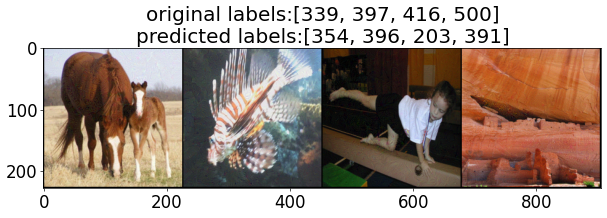

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: sorrel (339)
Image #2: puffer, pufferfish, blowfish, globefish (397)
Image #3: balance beam, beam (416)
Image #4: cliff dwelling (500)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Arabian camel, dromedary, Camelus dromedarius (354)
Image #2: lionfish (396)
Image #3: West Highland white terrier (203)
Image #4: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch (391)


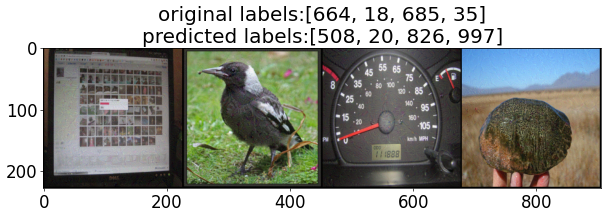

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: monitor (664)
Image #6: magpie (18)
Image #7: odometer, hodometer, mileometer, milometer (685)
Image #8: mud turtle (35)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: computer keyboard, keypad (508)
Image #6: water ouzel, dipper (20)
Image #7: stopwatch, stop watch (826)
Image #8: bolete (997)
[Step #0] Loss: 2.6540 Accuracy: 0.0000% Time elapsed: 2.0972s (total 16 images)
[Step #10] Loss: 2.7299 Accuracy: 0.0000% Time elapsed: 14.5927s (total 176 images)
[Step #20] Loss: 2.6130 Accuracy: 0.0000% Time elapsed: 27.1149s (total 336 images)
[Step #30] Loss: 2.6375 Accuracy: 0.0000% Time elapsed: 39.6627s (total 496 images)
[Step #40] Loss: 2.6750 Accuracy: 0.0000% Time elapsed: 52.2158s (total 656 images)
[Step #50] Loss: 2.6771 Accuracy: 0.0000% Time elapsed: 64.7492s (total 816 images)
[Step #60] Loss: 2.6591 Accuracy: 0.0000% Time elapsed: 77.2531s (total 976 images)
[Step #70] Loss: 2.6608 Accuracy: 0.0000% Time elapsed: 89.72

In [36]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=8.0, nb_iter=7, eps_iter=8.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 0.25

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


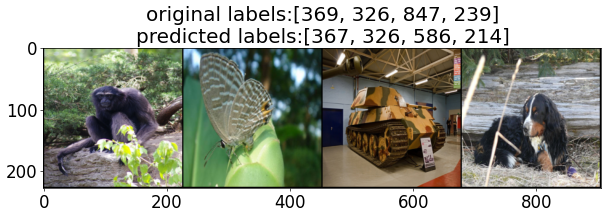

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: siamang, Hylobates syndactylus, Symphalangus syndactylus (369)
Image #2: lycaenid, lycaenid butterfly (326)
Image #3: tank, army tank, armored combat vehicle, armoured combat vehicle (847)
Image #4: Bernese mountain dog (239)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: chimpanzee, chimp, Pan troglodytes (367)
Image #2: lycaenid, lycaenid butterfly (326)
Image #3: half track (586)
Image #4: Gordon setter (214)


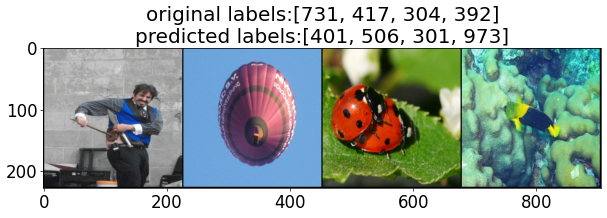

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: plunger, plumber's helper (731)
Image #6: balloon (417)
Image #7: leaf beetle, chrysomelid (304)
Image #8: rock beauty, Holocanthus tricolor (392)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: accordion, piano accordion, squeeze box (401)
Image #6: coil, spiral, volute, whorl, helix (506)
Image #7: ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle (301)
Image #8: coral reef (973)
[Step #0] Loss: 0.2865 Accuracy: 18.7500% Time elapsed: 2.0869s (total 16 images)
[Step #10] Loss: 0.3161 Accuracy: 26.1364% Time elapsed: 15.8785s (total 176 images)
[Step #20] Loss: 0.2970 Accuracy: 22.0238% Time elapsed: 29.5536s (total 336 images)
[Step #30] Loss: 0.3039 Accuracy: 21.5726% Time elapsed: 42.6437s (total 496 images)
[Step #40] Loss: 0.3061 Accuracy: 21.3415% Time elapsed: 55.5024s (total 656 images)
[Step #50] Loss: 0.3043 Accuracy: 21.6912% Time elapsed: 68.3202s (total 816 images)
[Step #60] Loss: 0.3090 Accuracy: 21.4139

In [38]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.L2ProjectedGradientDescentAttack(abs_stepsize=0.25/4, steps=7)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    _, adv_untargeted, _ = attack(fmodel, inputs, labels, epsilons=0.25) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))